# Projection of Death Probability in the future

AIM: based on past data on `DCIS_MORTALITA1/PROBDEATH` create a model for future projection of death probability.

Note that ISTAT projections in `DCIS_PREVDEM1` do not include `PROBDEATH`: there is only `DEATHRATE` but not by age.

In [1]:
import warnings 
from istatapi import discovery, retrieval
import numpy as np
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'vscode+notebook'

warnings.filterwarnings('ignore')
requests.urllib3.disable_warnings() # avoid "InsecureRequestWarning: Unverified HTTPS request is being made to host 'sdmx.istat.it'. Adding certificate verification is strongly advised"

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str

In [ ]:
dfdp = pd.read_csv("../data/deathprob_by_age_year.csv").set_index("age").rename(columns=int) # From Notebook 30

,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,
0,0.024431,0.023538,0.021786,0.020453,0.018872,0.017614,0.016245,0.015062,0.013304,0.012488,...,0.002976,0.002978,0.002962,0.002915,0.002918,0.002784,0.002632,0.002407,0.002346,0.002460
1,0.001161,0.001034,0.000992,0.000951,0.000931,0.000891,0.000880,0.000842,0.000818,0.000769,...,0.000217,0.000211,0.000190,0.000203,0.000204,0.000208,0.000191,0.000182,0.000175,0.000199
2,0.000803,0.000729,0.000687,0.000662,0.000643,0.000619,0.000617,0.000583,0.000570,0.000541,...,0.000163,0.000162,0.000148,0.000145,0.000145,0.000152,0.000143,0.000135,0.000125,0.000138
3,0.000580,0.000540,0.000499,0.000480,0.000460,0.000443,0.000448,0.000422,0.000415,0.000394,...,0.000122,0.000124,0.000115,0.000107,0.000109,0.000114,0.000110,0.000101,0.000094,0.000102
4,0.000450,0.000430,0.000392,0.000377,0.000353,0.000338,0.000347,0.000329,0.000326,0.000305,...,0.000095,0.000098,0.000092,0.000084,0.000089,0.000089,0.000088,0.000079,0.000076,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.830542,0.842068,0.840793,0.832899,0.820353,0.821158,0.830536,0.812013,0.827645,0.844510,...,0.803921,0.812349,0.783121,0.790757,0.785699,0.789470,0.825086,0.801922,0.827020,0.812427
116,0.840824,0.851811,0.851071,0.844183,0.832275,0.833640,0.842781,0.824728,0.840211,0.855815,...,0.823965,0.831453,0.805091,0.811518,0.807117,0.810286,0.843005,0.821794,0.844665,0.832323
117,0.849532,0.860006,0.859822,0.854056,0.842874,0.844825,0.853700,0.836179,0.851242,0.865447,...,0.842440,0.848947,0.825683,0.830815,0.825405,0.829654,0.859216,0.840126,0.860587,0.850653


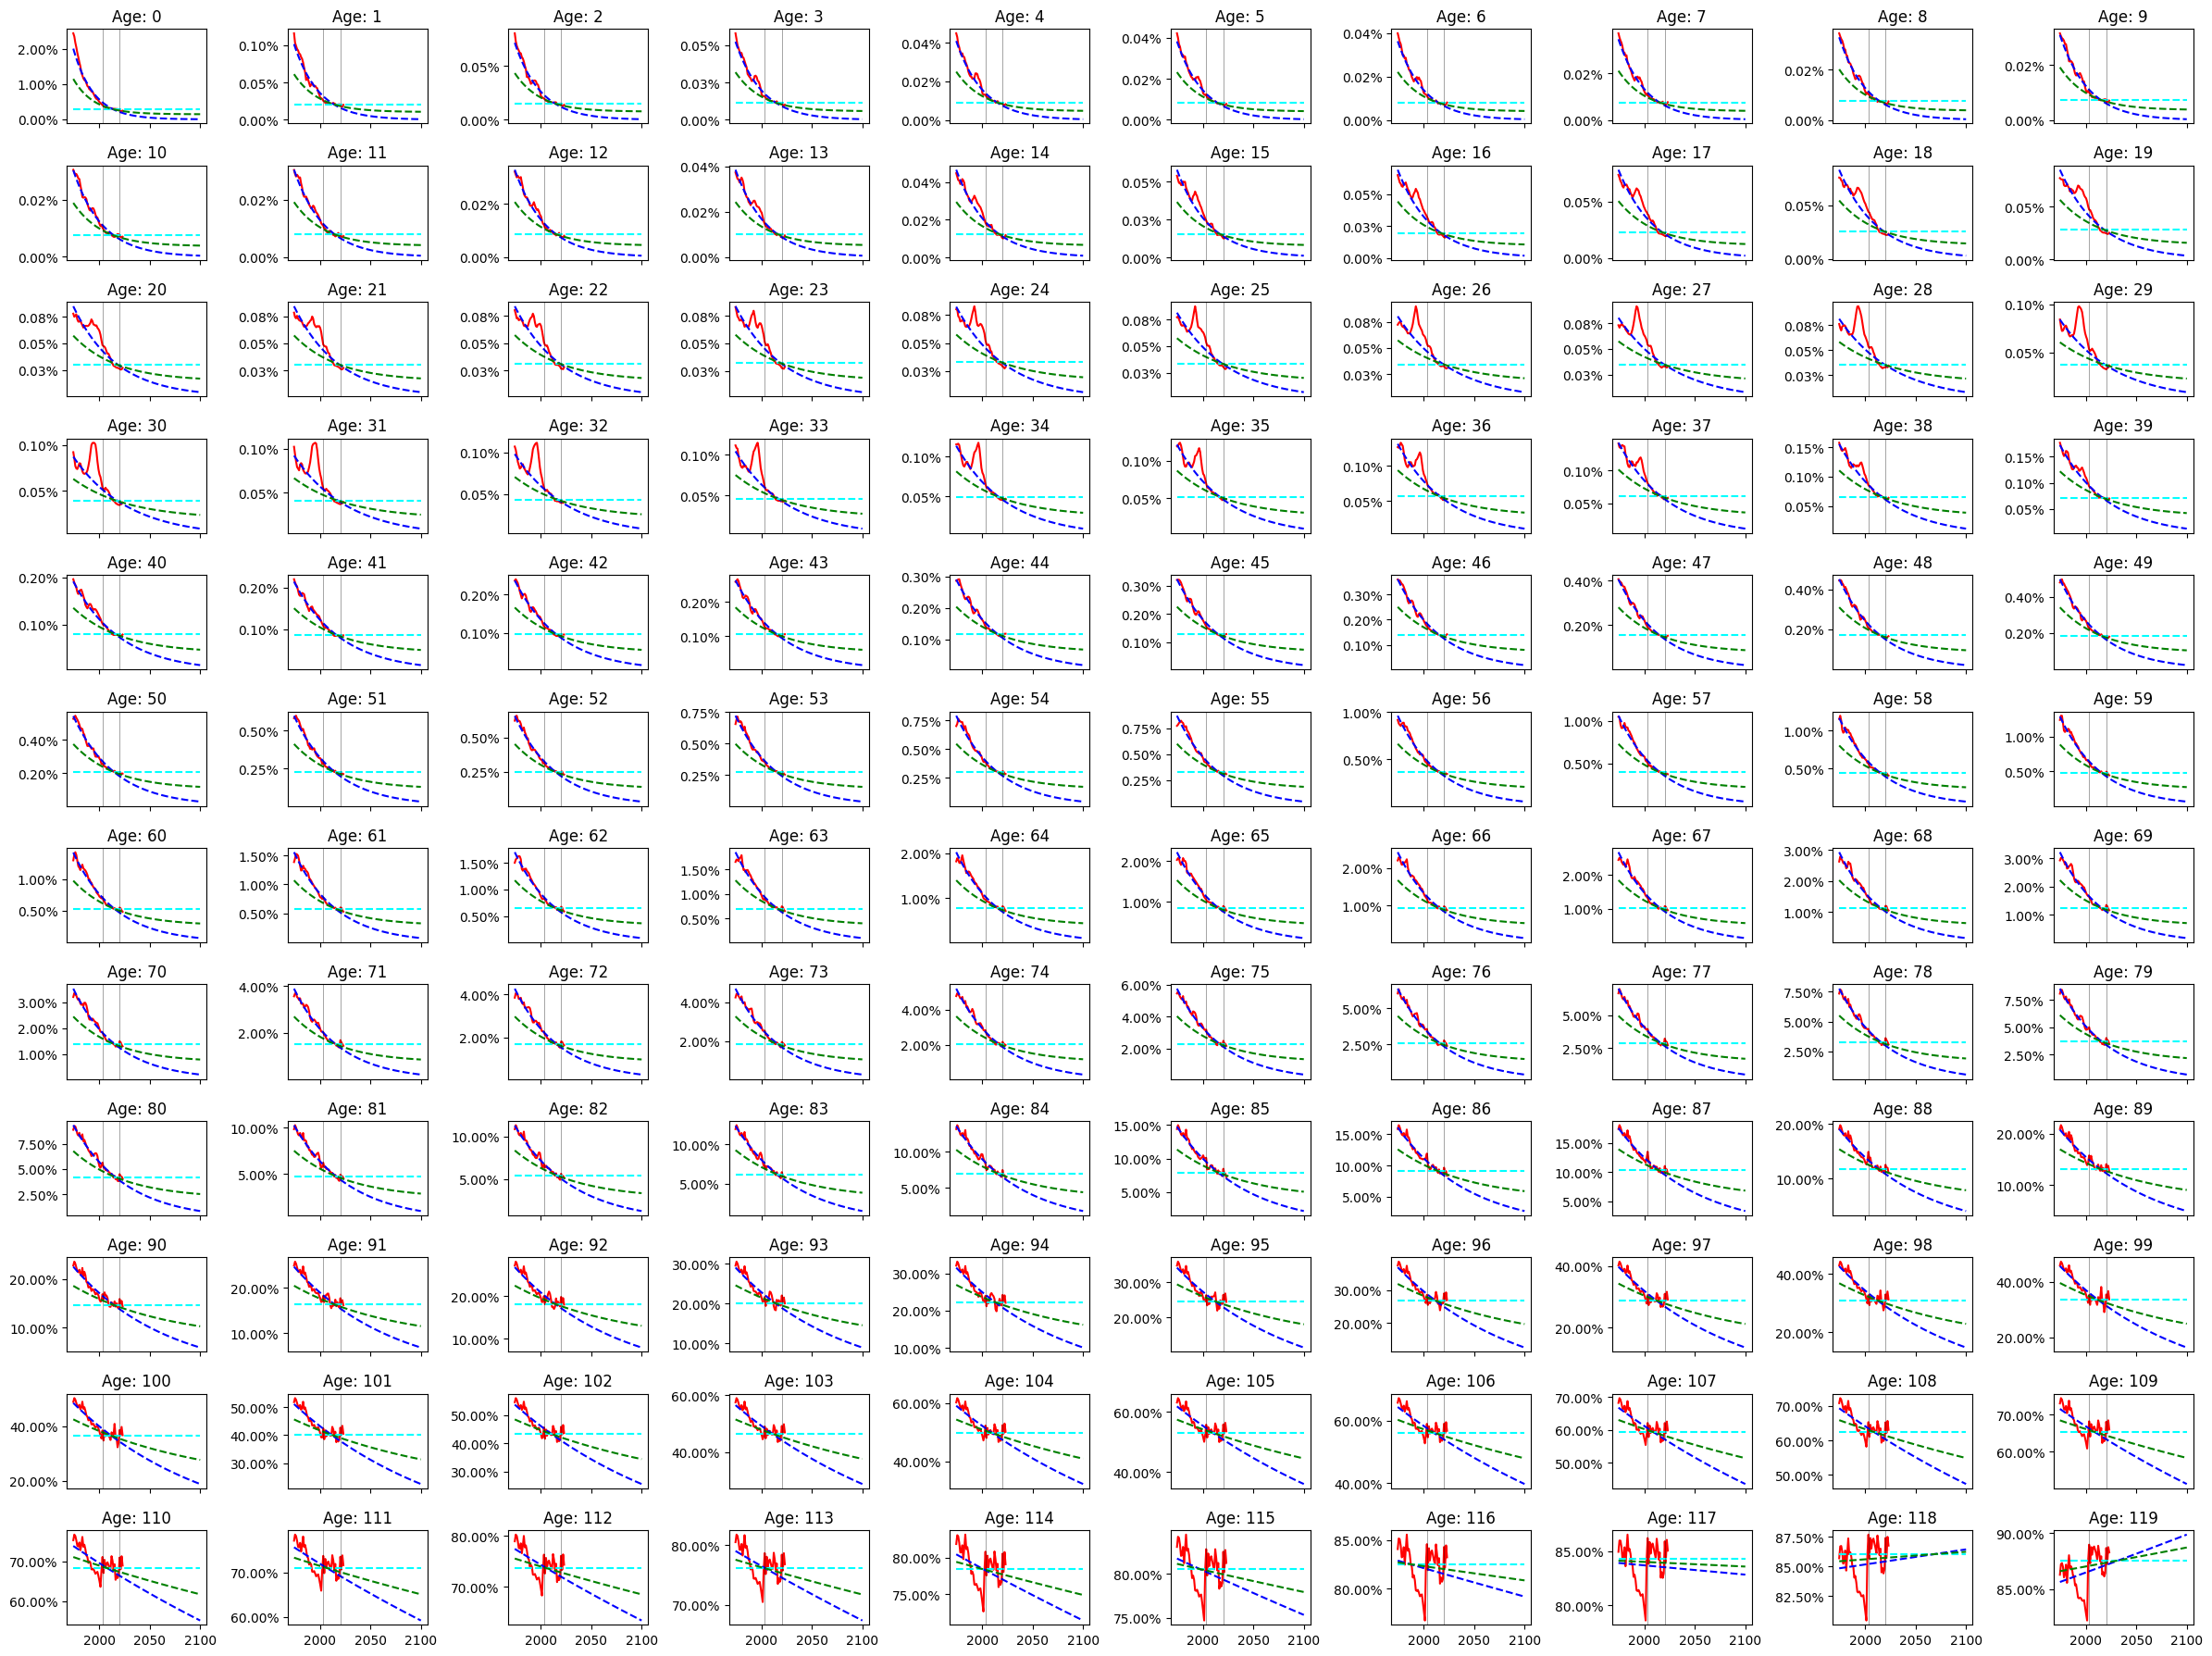

In [ ]:
start_year = dfdp.columns[0] # 2002
last_year = dfdp.columns[-1] # 2023 (or later if updated)
end_year = 2100

years_projection = list(range(start_year, end_year+1))

fit_coeff22 = {}
fit_polyn22 = {}
for age in dfdp.index:
    if 1 <= age <= 40: # remove years of possible drug-related deaths + heatwave + COVID-19
        years_excluded = list(range(1988, 1999+1)) + [2003, 2020, 2021]
        years_included = dfdp.columns.difference(years_excluded)
        fit_coeff22[age] = np.polyfit(years_included, np.log(dfdp.loc[age,years_included]), 1)
    else:
        years_excluded = [2003, 2020, 2021] # remove years of heatwave + COVID-19
        years_included = dfdp.columns.difference(years_excluded)
        fit_coeff22[age] = np.polyfit(years_included, np.log(dfdp.loc[age,years_included]), 1)
    fit_polyn22[age] = np.poly1d(fit_coeff22[age])

fig, axs = plt.subplots(12, 10, figsize=[24, 18], sharex=True)
dfdpj = pd.DataFrame(index=dfdp.index, columns=years_projection)
for iplot, age in enumerate(dfdp.index):
    ax = axs.flatten()[iplot]
    ax.plot(dfdp.columns, dfdp.loc[age] * 100, color="red")
    ax.plot(years_projection, np.exp(fit_polyn22[age](years_projection)) * 100, color="blue", linestyle="--")
    recent_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2022, 2023] # last ca. 10 years excluding COVID-19 - to improve automatically compunting 
    avg_recent = dfdp.loc[age, recent_years].mean()
    ax.plot(years_projection, avg_recent * 100 * np.ones(len(years_projection)), color="cyan", linestyle="--")
    mixed_proj = np.array([ np.mean([x, avg_recent]) for x in np.exp(fit_polyn22[age](years_projection))])
    dfdpj.loc[age] = mixed_proj
    ax.plot(years_projection, mixed_proj * 100, color="green", linestyle="--")
    ax.set_title(f"Age: {age}") 
    ax.axvline(2003, color="black", linestyle="-", lw=0.5, alpha=0.5) # heatwave - investigate in Notebook 53
    ax.axvline(2020, color="black", linestyle="-", lw=0.5, alpha=0.5) # COVID-19, also change in methodology (see Notebook 25)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.tight_layout()
# save to png
plt.savefig("../images_output/deathprob_by_age_year_projection.png", dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# save the projected death probabilities
dfdpj.loc[:, list(range(last_year+1, end_year+1))].to_csv("../data/deathprob_by_age_year_proj.csv", index=True)